# USA Car Accidents Prediction for 2020
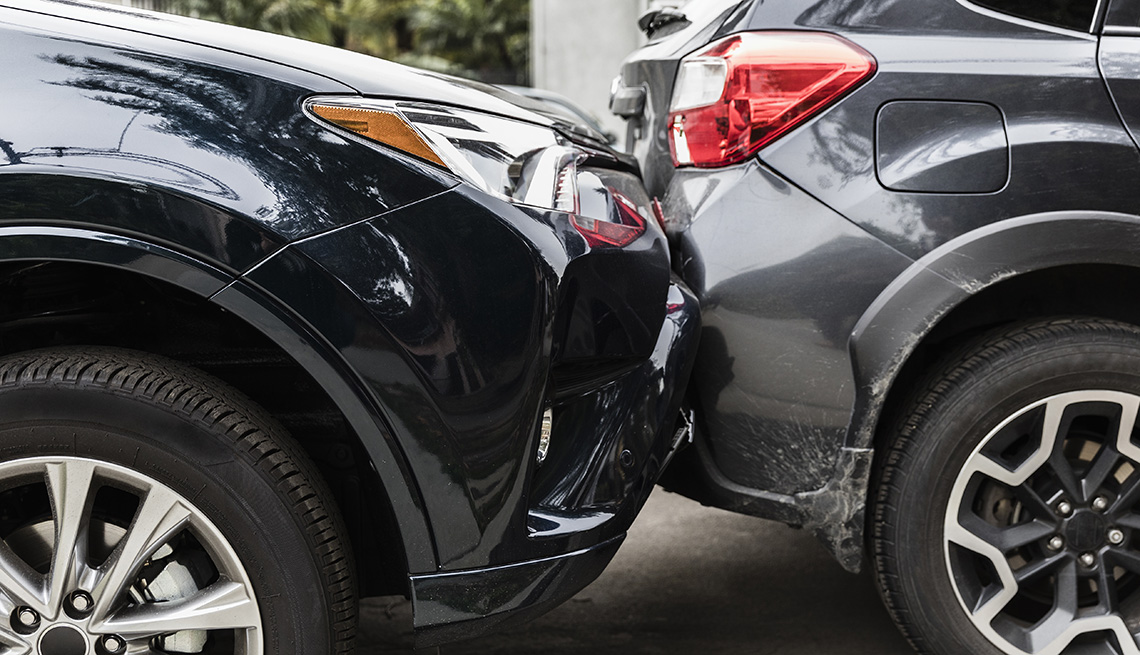

# Analysis:

- Machine Learning Problem: Classification
- Date Range: Feb 8 2016 through Jun 30 2020
- Target: Severity (impact of traffic flow)
- Train: Feb 2016 through Dec 2018
- Validation: 2019
- Test: Jan through Jun of 2020

# Added Features:

- Duration of accident
- Distance in feet
- Length of description
- Kind of street
- Calendar information

# Import and Setup

In [360]:
%%capture
# To time the whole notebook:
from time import time
start_time = time()

# Other:
import catboost
from catboost import CatBoostClassifier, Pool
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
import seaborn as sns
import shap
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# Libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas_profiling import ProfileReport

# Category:
import category_encoders
from category_encoders import OrdinalEncoder, OneHotEncoder

# Sklearn:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier

In [2]:
# This code enables intellisense.
%config IPCompleter.greedy=True

In [3]:
# To display all columns and more rows.
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# This code is to ignore copy warnings.
pd.options.mode.chained_assignment = None

In [4]:
# This will set the style for all
# bar plots:
plt.style.use('fivethirtyeight')

In [467]:
# CSV Links from my repo!
acc = 'https://media.githubusercontent.com/media/Lolo-17/USA-Car-Accident-Prediction/master/CSV%20Files/US_Accidents_June20.csv'
stt = 'https://media.githubusercontent.com/media/Lolo-17/USA-Car-Accident-Prediction/master/CSV%20Files/Street_Kind_Column.csv'
dur = 'https://media.githubusercontent.com/media/Lolo-17/USA-Car-Accident-Prediction/master/CSV%20Files/Duration_Column.csv'

In [468]:
# Reading my us accidents dataset and parsing dates.
USA_Accidents = pd.read_csv(acc, 
                            infer_datetime_format=True, parse_dates=['Start_Time', 'End_Time'])

# Reading street_kind column to concat into main dataframe.
Street_Kind = pd.read_csv(stt)

# Reading time duration column to concat into main dataframe.
Duration = pd.read_csv(dur)

In [6]:
# Making a copy so I don't have to re-run this giant
# dataset of 3.5 million observations.
df = USA_Accidents.copy()

In [ ]:
%%capture

# This create a pandas profile report and saves
# a html link in current directory.
profile = ProfileReport(df, minimal=True)
profile.to_file("Pandas Profile.html")

# EDA

In [7]:
# To display shape of dataframe and first 5 rows.
print('Shape of USA Car Accidents Dataframe:', df.shape)
df.head()

Shape of USA Car Accidents Dataframe: (3513617, 49)


,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [8]:
# To inspect datatypes and null value counts.
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 49 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ID                     3513617 non-null  object        
 1   Source                 3513617 non-null  object        
 2   TMC                    2478818 non-null  float64       
 3   Severity               3513617 non-null  int64         
 4   Start_Time             3513617 non-null  datetime64[ns]
 5   End_Time               3513617 non-null  datetime64[ns]
 6   Start_Lat              3513617 non-null  float64       
 7   Start_Lng              3513617 non-null  float64       
 8   End_Lat                1034799 non-null  float64       
 9   End_Lng                1034799 non-null  float64       
 10  Distance(mi)           3513617 non-null  float64       
 11  Description            3513616 non-null  object        
 12  Number                 12507

In [9]:
# This is to compare if my for loop in a another
# notebook did a good job at picking up string values
# from the street column and creating the street kind column.
a = df['Street']
b = Street_Kind['Street_Kind']
ab = pd.concat([a,b], axis=1)
ab[2000025:2000050]

,Street,Street_Kind
2000025,I-5 N,Interstate
2000026,I-10 E,Interstate
2000027,Santa Ana Fwy S,Freeway
2000028,3rd St,Street
2000029,I-10 E,Interstate
2000030,I-105 E,Interstate
2000031,I-90 E,Interstate
2000032,Smith St,Street
2000033,State Highway 77,Highway
2000034,I-90 E,Interstate


# Wrangling

In [10]:
# Concatenating street kind and duration columns into main dataframe.
df = pd.concat([df, Street_Kind], axis=1)
df = pd.concat([df, Duration], axis=1)

# Changing index to year.
df.index = pd.DatetimeIndex(df['Start_Time']).year
df.index.name = 'Year'

# Changing target feature for better readability.
df['Severity'] = df['Severity'].replace({1:'Least Impact', 
                                         2:'Impactful', 
                                         3:'More Impactful', 
                                         4:'Significant Impact'})

# Creating new features of calendar statistics.
# 1.) Month name abbreviated.
# 2.) Day of the month as integer.
# 3.) The weekday name.
# 4.) Week number of the year.
# 5.) Weekend yes or no.
# 6.) Hour of day.
df['Month'] = df['Start_Time'].dt.strftime('%B')
df['Day_of_Month'] = (df['Start_Time'].dt.day)
df['Weekday'] = df['Start_Time'].dt.strftime('%A')
df['Week_Num_Year'] = df['Start_Time'].dt.strftime('%W')
df['Weekend'] = ((df['Weekday'] == 'Saturday') | (df['Weekday'] == 'Sunday')).astype('int64')
df['Hour_of_Day'] = df['Start_Time'].dt.strftime('%H')

# Creating a new feature of accident distance effect in feet.
df['Distance_Feet'] = df['Distance(mi)'] * 5280

# Creating a new feature of description lenght.
df['Description_Length'] = (df['Description'].str.len()).astype(object)

# Changing this column to only display timezone.
df['Timezone'] = df['Timezone'].str.strip('US/')

# A list of columns with boolean values.
bools = ['Bump', 'Crossing', 'Railway', 'Stop', 
         'Traffic_Calming', 'Traffic_Signal']

# To replace with ones and zeros.
df[bools] = df[bools].replace({False:0,
                                True:1})

# To sort dataframe by year.
df = df.sort_index()

In [11]:
# To view all columns and to select keeping
# columns easily.
df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Street_Kind', 'Duration', 'Month',
       'Day_of_Month', 'Weekday', 'Week_Num_Year', 'Weekend', 'Hour_of_Day',
       'Distance_Feet', 'Description_Length'],
      dtype='object')

In [12]:
# These are the features I am keeping for my ML models.
keeping = ['Month', 'Day_of_Month', 'Weekday', 'Week_Num_Year', 'Weekend', 'Hour_of_Day',
           'Timezone', 'State', 'City', 'Airport_Code', 'Start_Lat', 'Start_Lng', 'Side', 
           'Street_Kind', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Direction', 
           'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Bump', 'Crossing',
           'Railway', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Sunrise_Sunset', 'Duration',  
           'Distance_Feet', 'Description_Length',  'Source', 'Severity'
]

# Replace df with keeping columns.
df = df[keeping]

In [13]:
# New dataframe after engineering.
df.head()

,Month,Day_of_Month,Weekday,Week_Num_Year,Weekend,Hour_of_Day,Timezone,State,City,Airport_Code,Start_Lat,Start_Lng,Side,Street_Kind,Temperature(F),Humidity(%),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Bump,Crossing,Railway,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Duration,Distance_Feet,Description_Length,Source,Severity
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016,February,8,Monday,06,0,05,Eastern,OH,Dayton,KFFO,39.865147,-84.058723,R,Interstate,36.9,91.0,10.0,Calm,NaN,0.02,Light Rain,0,0,0,0,0,0,Night,5.2,52.8,85,MapQuest,More Impactful
2016,September,3,Saturday,35,1,10,Central,TX,Dallas,KRBD,32.642422,-96.823097,R,Highway,80.1,62.0,10.0,ESE,6.9,NaN,Clear,0,0,0,0,0,0,Day,0.5,0.0,52,MapQuest,More Impactful
2016,September,3,Saturday,35,1,10,Central,TX,Dallas,KDAL,32.775295,-96.785889,R,Freeway,81.0,56.0,10.0,SE,8.1,NaN,Partly Cloudy,0,0,0,0,0,0,Day,0.5,0.0,67,MapQuest,More Impactful
2016,September,3,Saturday,35,1,10,Central,TX,Dallas,KDAL,32.792728,-96.792397,R,Avenue,81.0,56.0,10.0,SE,8.1,NaN,Partly Cloudy,0,0,0,0,0,0,Day,0.5,0.0,37,MapQuest,Impactful
2016,September,3,Saturday,35,1,10,Central,TX,Houston,KHOU,29.685095,-95.277161,R,Street,84.9,63.0,10.0,ENE,5.8,NaN,Clear,0,0,0,0,0,0,Day,0.5,0.0,53,MapQuest,More Impactful


# Split Data

In [14]:
target = 'Severity'
y = df[target]
X = df.drop(target, axis=1)

In [194]:
# Train: Feb 2016 through Dec 2018
# Validation: 2019
# Test: Jan through Jun of 2020

tr_dt = df.index < 2019
vl_dt = df.index  == 2019
tt_dt = df.index  == 2020

X_train, y_train = X.loc[tr_dt], y.loc[tr_dt]
X_val, y_val = X.loc[vl_dt], y.loc[vl_dt]
X_test, y_test = X.loc[tt_dt], y.loc[tt_dt]

## Shapes

In [16]:
print('X Training Data Shape', X_train.shape)
print('X Validation Data Shape', X_val.shape)
print('X Test Data Shape', X_test.shape)

X Training Data Shape (2020697, 32)
X Validation Data Shape (953733, 32)
X Test Data Shape (539187, 32)


In [17]:
print('y Training Data Shape', y_train.shape)
print('y Validation Data Shape', y_val.shape)
print('y Test Data Shape', y_test.shape)

y Training Data Shape (2020697,)
y Validation Data Shape (953733,)
y Test Data Shape (539187,)


# Baseline

In [18]:
print('Value counts of car accidents severity impact on traffic flow:')
print(y.value_counts())

Value counts of car accidents severity impact on traffic flow:
Impactful             2373210
More Impactful         998913
Significant Impact     112320
Least Impact            29174
Name: Severity, dtype: int64


In [19]:
print('Ratio of car accidents severity impact on traffic:')
print(y.value_counts(normalize=True))

Ratio of car accidents severity impact on traffic:
Impactful             0.675432
More Impactful        0.284298
Significant Impact    0.031967
Least Impact          0.008303
Name: Severity, dtype: float64


In [173]:
print('Baseline Accuracy of car accidents severity impact on traffic:', 
      round(y.value_counts(normalize=True).max(),3))

Baseline Accuracy of car accidents severity impact on traffic: 0.675


# Models

## `OrdinalEncoder` + `CatBoostClassifier`
- To be used in heroku app

In [200]:
%%capture

kbest = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    SelectKBest(k=16),
    CatBoostClassifier(iterations=10)
)

kbest.fit(X_train, y_train);

kcols = X_train.columns[kbest.named_steps['selectkbest'].get_support()].drop(labels=['Timezone', 
                                                                             'City', 
                                                                             'Start_Lat', 
                                                                             'Start_Lng', 
                                                                             'Source', 
                                                                             'Airport_Code'])
X_train = X_train[kcols]
X_val= X_val[kcols]
X_test = X_test[kcols]

In [144]:
ord_cat_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    CatBoostClassifier(iterations=500, random_state=17, learning_rate=0.85),
    verbose=True
)

ord_cat_model.fit(X_train, y_train);

[Pipeline] .... (step 1 of 3) Processing ordinalencoder, total=   1.7s
[Pipeline] ..... (step 2 of 3) Processing simpleimputer, total=   0.3s
0:	learn: 0.6571081	total: 290ms	remaining: 2m 24s
1:	learn: 0.5739065	total: 566ms	remaining: 2m 21s
2:	learn: 0.5491627	total: 812ms	remaining: 2m 14s
3:	learn: 0.5297894	total: 1.12s	remaining: 2m 19s
4:	learn: 0.5228544	total: 1.38s	remaining: 2m 16s
5:	learn: 0.5185200	total: 1.65s	remaining: 2m 15s
6:	learn: 0.5164987	total: 1.9s	remaining: 2m 14s
7:	learn: 0.5132963	total: 2.2s	remaining: 2m 15s
8:	learn: 0.5099173	total: 2.46s	remaining: 2m 14s
9:	learn: 0.5065169	total: 2.72s	remaining: 2m 13s
10:	learn: 0.5049941	total: 2.98s	remaining: 2m 12s
11:	learn: 0.5013734	total: 3.28s	remaining: 2m 13s
12:	learn: 0.4996746	total: 3.56s	remaining: 2m 13s
13:	learn: 0.4962012	total: 3.87s	remaining: 2m 14s
14:	learn: 0.4934167	total: 4.16s	remaining: 2m 14s
15:	learn: 0.4906337	total: 4.44s	remaining: 2m 14s
16:	learn: 0.4888614	total: 4.7s	remai

156:	learn: 0.6919860	total: 43.5s	remaining: 1m 34s
157:	learn: 0.6919433	total: 43.7s	remaining: 1m 34s
158:	learn: 0.6918898	total: 44s	remaining: 1m 34s
159:	learn: 0.6918407	total: 44.2s	remaining: 1m 33s
160:	learn: 0.6917848	total: 44.5s	remaining: 1m 33s
161:	learn: 0.6917234	total: 44.7s	remaining: 1m 33s
162:	learn: 0.6916503	total: 45s	remaining: 1m 33s
163:	learn: 0.6916131	total: 45.3s	remaining: 1m 32s
164:	learn: 0.6915831	total: 45.5s	remaining: 1m 32s
165:	learn: 0.6915163	total: 45.8s	remaining: 1m 32s
166:	learn: 0.6914724	total: 46.1s	remaining: 1m 31s
167:	learn: 0.6914433	total: 46.3s	remaining: 1m 31s
168:	learn: 0.6914117	total: 46.6s	remaining: 1m 31s
169:	learn: 0.6898179	total: 46.9s	remaining: 1m 31s
170:	learn: 0.6897705	total: 47.1s	remaining: 1m 30s
171:	learn: 0.6896350	total: 47.4s	remaining: 1m 30s
172:	learn: 0.6896011	total: 47.7s	remaining: 1m 30s
173:	learn: 0.6895837	total: 47.9s	remaining: 1m 29s
174:	learn: 0.6876489	total: 48.2s	remaining: 1m 2

312:	learn: 0.6556985	total: 1m 25s	remaining: 50.9s
313:	learn: 0.6543429	total: 1m 25s	remaining: 50.6s
314:	learn: 0.6543246	total: 1m 25s	remaining: 50.4s
315:	learn: 0.6542395	total: 1m 26s	remaining: 50.1s
316:	learn: 0.6542118	total: 1m 26s	remaining: 49.8s
317:	learn: 0.6542008	total: 1m 26s	remaining: 49.5s
318:	learn: 0.6541830	total: 1m 26s	remaining: 49.3s
319:	learn: 0.6524365	total: 1m 27s	remaining: 49s
320:	learn: 0.6523250	total: 1m 27s	remaining: 48.7s
321:	learn: 0.6522780	total: 1m 27s	remaining: 48.5s
322:	learn: 0.6522490	total: 1m 27s	remaining: 48.2s
323:	learn: 0.6513749	total: 1m 28s	remaining: 47.9s
324:	learn: 0.6513595	total: 1m 28s	remaining: 47.6s
325:	learn: 0.6512385	total: 1m 28s	remaining: 47.4s
326:	learn: 0.6512198	total: 1m 28s	remaining: 47.1s
327:	learn: 0.6511949	total: 1m 29s	remaining: 46.8s
328:	learn: 0.6511382	total: 1m 29s	remaining: 46.5s
329:	learn: 0.6511069	total: 1m 29s	remaining: 46.3s
330:	learn: 0.6510915	total: 1m 30s	remaining: 4

468:	learn: 0.6273221	total: 2m 6s	remaining: 8.39s
469:	learn: 0.6273140	total: 2m 7s	remaining: 8.12s
470:	learn: 0.6273097	total: 2m 7s	remaining: 7.85s
471:	learn: 0.6273027	total: 2m 7s	remaining: 7.58s
472:	learn: 0.6272839	total: 2m 7s	remaining: 7.3s
473:	learn: 0.6272536	total: 2m 8s	remaining: 7.03s
474:	learn: 0.6272171	total: 2m 8s	remaining: 6.76s
475:	learn: 0.6271702	total: 2m 8s	remaining: 6.49s
476:	learn: 0.6271602	total: 2m 9s	remaining: 6.22s
477:	learn: 0.6269329	total: 2m 9s	remaining: 5.95s
478:	learn: 0.6269176	total: 2m 9s	remaining: 5.68s
479:	learn: 0.6268939	total: 2m 9s	remaining: 5.41s
480:	learn: 0.6268731	total: 2m 10s	remaining: 5.14s
481:	learn: 0.6268548	total: 2m 10s	remaining: 4.87s
482:	learn: 0.6268306	total: 2m 10s	remaining: 4.6s
483:	learn: 0.6268107	total: 2m 10s	remaining: 4.33s
484:	learn: 0.6267900	total: 2m 11s	remaining: 4.06s
485:	learn: 0.6267711	total: 2m 11s	remaining: 3.79s
486:	learn: 0.6267509	total: 2m 11s	remaining: 3.52s
487:	le

## For Visual Studio Code

In [23]:
X_train.Hour_of_Day = X_train.Hour_of_Day.astype('int64')

import joblib
from joblib import dump

print(f'CatBoost=={catboost.__version__}')
print(f'category_encoders=={category_encoders.__version__}')
print(f'joblib=={joblib.__version__}')

dump(ord_cat_model, 'CatBoost.joblib', compress=True)

CatBoost==0.24.1
category_encoders==2.2.2
joblib==0.16.0


['CatBoost.joblib']

### Metrics

In [145]:
cat_train_score = round(ord_cat_model.score(X_train, y_train),3)
cat_val_score = round(ord_cat_model.score(X_val, y_val),3)
cat_test_score = round(ord_cat_model.score(X_test, y_test),3)

print('CatBoost Training Accuracy:', cat_train_score)
print('CatBoost Validation Accuracy:', cat_val_score)
print('CatBoost Test Accuracy:', cat_test_score)

CatBoost Training Accuracy: 0.808
CatBoost Validation Accuracy: 0.797
CatBoost Test Accuracy: 0.711


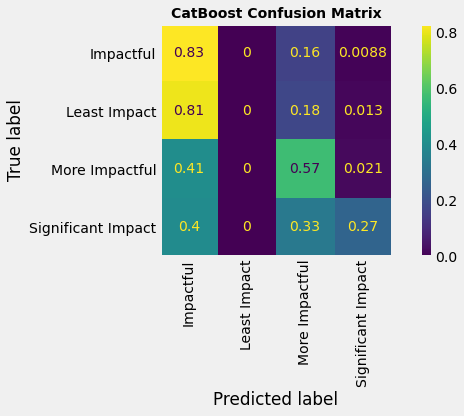

In [25]:
fig, ax1 = plt.subplots(figsize=(9,6))

plot_confusion_matrix(ord_cat_model, X_test, y_test, 
                      normalize='true', ax=ax1, xticks_rotation='vertical')

ax1.set_title('CatBoost Confusion Matrix', fontsize=14, fontweight='bold')
ax1.grid(False)
plt.tight_layout()
plt.savefig('Confusion Matrix from CatBoost')
plt.show()

### Cross-Validation

In [26]:
test_ord_cat_c = cross_val_score(ord_cat_model, X_test, y_test,
                                         cv=5, n_jobs=-1, scoring='accuracy', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [27]:
print('CatBoost Test Cross Validation Score Mean [5 Folds]:', round(test_ord_cat_c.mean(),3))

CatBoost Test Cross Validation Score Mean [5 Folds]: 0.747


### Tuning
- With `RandomizedSearchCV`

In [43]:
cat_params = {
              'catboostclassifier__depth':range(1,16,4),
              'catboostclassifier__learning_rate':[.75,.85,.95],
              'catboostclassifier__l2_leaf_reg':range(1,101,30),
              'catboostclassifier__iterations':[10]
             }

In [44]:
ord_rs_cat_model = RandomizedSearchCV(
    ord_cat_model,
    cat_params, 
    n_iter=1, 
    cv=10, 
    verbose=1, 
    n_jobs=-1
)

ord_rs_cat_model.fit(X_train, y_train);

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.4s finished


[Pipeline] .... (step 1 of 3) Processing ordinalencoder, total=   2.5s
[Pipeline] ..... (step 2 of 3) Processing simpleimputer, total=   0.3s
0:	learn: 0.6293319	total: 814ms	remaining: 7.33s
1:	learn: 0.5608729	total: 1.6s	remaining: 6.39s
2:	learn: 0.5313885	total: 2.35s	remaining: 5.49s
3:	learn: 0.5161765	total: 3.13s	remaining: 4.7s
4:	learn: 0.5094152	total: 4.11s	remaining: 4.11s
5:	learn: 0.5022932	total: 5.03s	remaining: 3.36s
6:	learn: 0.4963567	total: 6.01s	remaining: 2.58s
7:	learn: 0.4932541	total: 7s	remaining: 1.75s
8:	learn: 0.4862034	total: 8.01s	remaining: 890ms
9:	learn: 0.4813332	total: 9.1s	remaining: 0us
[Pipeline]  (step 3 of 3) Processing catboostclassifier, total=  10.8s


In [45]:
rs_cat_train_score = round(ord_rs_cat_model.score(X_train, y_train),3)
rs_cat_val_score = round(ord_rs_cat_model.score(X_val, y_val),3)
rs_cat_test_score = round(ord_rs_cat_model.score(X_test, y_test),3)

print('Randomized Search With CatBoost Training Accuracy:', rs_cat_train_score)
print('Randomized Search With CatBoost Validation Accuracy:', rs_cat_val_score)
print('Randomized Search With CatBoost Test Accuracy:', rs_cat_test_score)

Randomized Search With CatBoost Training Accuracy: 0.787
Randomized Search With CatBoost Validation Accuracy: 0.776
Randomized Search With CatBoost Test Accuracy: 0.682


## `OrdinalEncoder` + `LogisticRegression`

In [66]:
ord_ltr_model = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(),
    LogisticRegression(penalty='elasticnet', random_state=17, l1_ratio=.40,
                       solver='saga', max_iter=100, multi_class='ovr', n_jobs=-1,
                       C=.10),
    verbose=True
)

ord_ltr_model.fit(X_train, y_train);

[Pipeline] .... (step 1 of 4) Processing ordinalencoder, total=   1.7s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.4s
[Pipeline] ..... (step 3 of 4) Processing simpleimputer, total=   0.2s
[Pipeline]  (step 4 of 4) Processing logisticregression, total= 1.5min


### Metrics

In [67]:
ltr_train_score = round(ord_ltr_model.score(X_train, y_train),3)
ltr_val_score = round(ord_ltr_model.score(X_val, y_val),3)
ltr_test_score = round(ord_ltr_model.score(X_test, y_test),3)

print('Logistic Training Accuracy:', ltr_train_score)
print('Logistic Validation Accuracy:', ltr_val_score)
print('Logistic Test Accuracy:', ltr_test_score)

Logistic Training Accuracy: 0.675
Logistic Validation Accuracy: 0.694
Logistic Test Accuracy: 0.626


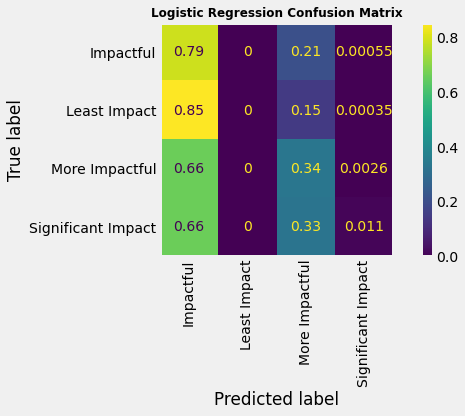

In [68]:
fig, ax1 = plt.subplots(figsize=(9,6))

plot_confusion_matrix(ord_ltr_model, X_test, y_test,
                      normalize='true', ax=ax1, xticks_rotation='vertical')

ax1.set_title('Logistic Regression Confusion Matrix', fontsize=12, fontweight='bold')
ax1.grid(False)
plt.tight_layout()
plt.savefig('Confusion Matrix from LogisticRegression')
plt.show()

### Cross-Validation

In [69]:
test_ord_ltr_c = cross_val_score(ord_ltr_model, X_test, y_test,
                                         cv=5, n_jobs=-1, scoring='accuracy', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


In [70]:
print('Logistic Regression Test Cross Validation Score Mean [5 Folds]:', round(test_ord_ltr_c.mean(),3))

Logistic Regression Test Cross Validation Score Mean [5 Folds]: 0.705


### Tuning
- With `RandomizedSearchCV`

In [118]:
ltr_params = {
              'logisticregression__max_iter':[10],
             }

In [119]:
ord_rs_ltr_model = RandomizedSearchCV(
    ord_ltr_model,
    ltr_params, 
    n_iter=1, 
    cv=10, 
    verbose=1, 
    n_jobs=-1
)

ord_rs_ltr_model.fit(X_train, y_train);

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.1s finished


[Pipeline] .... (step 1 of 4) Processing ordinalencoder, total=   1.9s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.4s
[Pipeline] ..... (step 3 of 4) Processing simpleimputer, total=   0.2s
[Pipeline]  (step 4 of 4) Processing logisticregression, total=  13.6s


In [120]:
rs_ltr_train_score = round(ord_rs_ltr_model.score(X_train, y_train),3)
rs_ltr_val_score = round(ord_rs_ltr_model.score(X_val, y_val),3)
rs_ltr_test_score = round(ord_rs_ltr_model.score(X_test, y_test),3)

print('Randomized Search With Logistic Regression Training Accuracy:', rs_ltr_train_score)
print('Randomized Search With Logistic Regression Validation Accuracy:', rs_ltr_val_score)
print('Randomized Search With Logistic Regression Test Accuracy:', rs_ltr_test_score)

Randomized Search With Logistic Regression Training Accuracy: 0.675
Randomized Search With Logistic Regression Validation Accuracy: 0.694
Randomized Search With Logistic Regression Test Accuracy: 0.626


## `OrdinalEncoder` + `RandomForestClassifier`

In [98]:
ord_forest_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17, 
                           bootstrap=True, warm_start=True, oob_score=True),
    verbose=True
)

ord_forest_model.fit(X_train, y_train);

[Pipeline] .... (step 1 of 3) Processing ordinalencoder, total=   1.7s
[Pipeline] ..... (step 2 of 3) Processing simpleimputer, total=   0.3s
[Pipeline]  (step 3 of 3) Processing randomforestclassifier, total= 1.6min


### Metrics

In [99]:
forest_train_score = round(ord_forest_model.score(X_train, y_train),3)
forest_val_score = round(ord_forest_model.score(X_val, y_val),3)
forest_test_score = round(ord_forest_model.score(X_test, y_test),3)

print('Random Forest Training Accuracy:', forest_train_score)
print('Random Forest Validation Accuracy:', forest_val_score)
print('Random Forest Test Accuracy:', forest_test_score)

Random Forest Training Accuracy: 0.896
Random Forest Validation Accuracy: 0.772
Random Forest Test Accuracy: 0.688


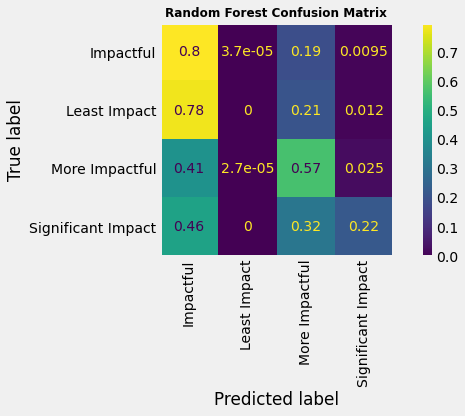

In [102]:
fig, ax1 = plt.subplots(figsize=(9,6))

plot_confusion_matrix(ord_forest_model, X_test, y_test, 
                      normalize='true', ax=ax1, xticks_rotation='vertical')

ax1.set_title('Random Forest Confusion Matrix', fontsize=12, fontweight='bold')
ax1.grid(False)
plt.tight_layout()
plt.savefig('Confusion Matrix from Forest')
plt.show()

### Cross-Validation

In [103]:
test_ord_forest_c = cross_val_score(ord_forest_model, X_test, y_test, 
                                    cv=5, n_jobs=-1, scoring='accuracy', verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.6s finished


In [104]:
print('Forest Test Cross Validation Scores [5 Folds]:', round(test_ord_forest_c.mean(),3))

Forest Test Cross Validation Scores [5 Folds]: 0.719


### Tuning
- With `RandomizedSearchCV`

In [121]:
forest_params = {
              'randomforestclassifier__max_depth':range(1,36,5),
              'randomforestclassifier__n_estimators':[10],
             }

In [122]:
ord_rs_forest_model = RandomizedSearchCV(
    ord_forest_model,
    forest_params, 
    n_iter=1, 
    cv=10, 
    verbose=1, 
    n_jobs=-1
)

ord_rs_forest_model.fit(X_train, y_train);

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   51.4s finished


[Pipeline] .... (step 1 of 3) Processing ordinalencoder, total=   2.0s
[Pipeline] ..... (step 2 of 3) Processing simpleimputer, total=   0.3s
[Pipeline]  (step 3 of 3) Processing randomforestclassifier, total=   7.7s


In [123]:
rs_forest_train_score = round(ord_rs_forest_model.score(X_train, y_train),3)
rs_forest_val_score = round(ord_rs_forest_model.score(X_val, y_val),3)
rs_forest_test_score = round(ord_rs_forest_model.score(X_test, y_test),3)

print('Randomized Search With Forest Training Accuracy:', rs_forest_train_score)
print('Randomized Search With Forest Validation Accuracy:', rs_forest_val_score)
print('Randomized Search With Forest Test Accuracy:', rs_forest_test_score)

Randomized Search With Forest Training Accuracy: 0.779
Randomized Search With Forest Validation Accuracy: 0.778
Randomized Search With Forest Test Accuracy: 0.683


# Evaluation

## Confusion Matrices

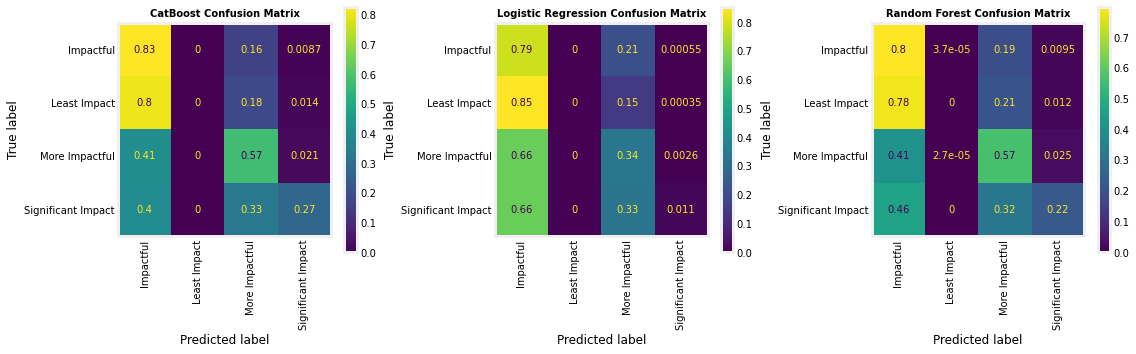

In [164]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(16,5))

plot_confusion_matrix(ord_cat_model, X_test, y_test, 
                      normalize='true', ax=ax1, xticks_rotation='vertical')

plot_confusion_matrix(ord_ltr_model, X_test, y_test, 
                      normalize='true', ax=ax2, xticks_rotation='vertical')

plot_confusion_matrix(ord_forest_model, X_test, y_test, 
                      normalize='true', ax=ax3, xticks_rotation='vertical')

ax1.set_title('CatBoost Confusion Matrix', fontsize=10, fontweight='bold')
ax2.set_title('Logistic Regression Confusion Matrix', fontsize=10, fontweight='bold')
ax3.set_title('Random Forest Confusion Matrix', fontsize=10, fontweight='bold')
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
plt.tight_layout()
fig.savefig('Confusion Matrix from Cat-Log-For', dpi=1200)
plt.show()

## Models Scores Perfomances

In [166]:
base = round(y.value_counts(normalize=True).max(),3) #Baseline
ct = cat_test_score #Ordinal + Catboost test score
cr = rs_cat_test_score #Ordinal + Catboost + Randomized test score
lt = ltr_test_score #Ordinal + Logistic test score
lr = rs_ltr_test_score #Ordinal + Logistic + Randomized test score
ft = forest_test_score #Ordinal + Forest test score
fr = rs_forest_test_score #Ordinal + Forest + Randomized test score

In [185]:
models = [base, ct, cr, lt, lr, ft, fr]
col_n = ['Ordinal Logistic Randomized', 'Ordinal Logistic', 'Baseline', 'Ordinal CatBoost Randomized', 
         'Ordinal Forest Randomized', 'Ordinal Forest', 'Ordinal Catboost']

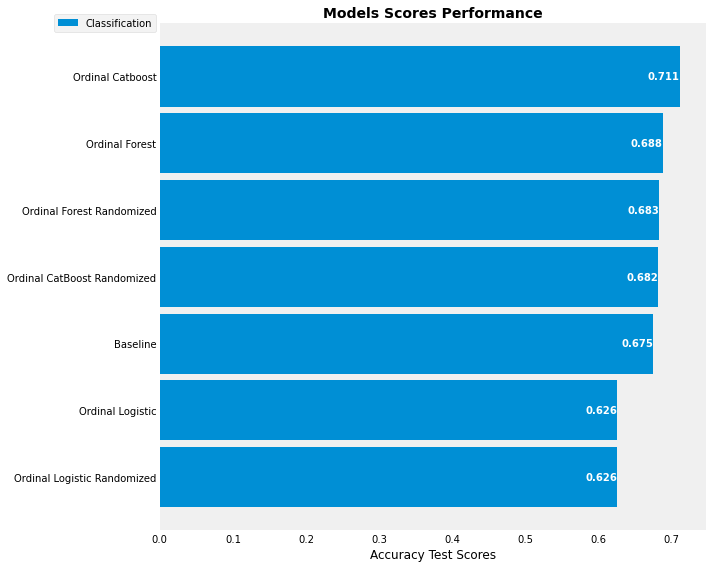

In [187]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(col_n, sorted(models), height=.9, label='Classification')

for i, v in enumerate(sorted(models)):
    ax.text(v, i, str(round(v, 3)), va='center', ha='right', color='white',
            fontweight='bold')

ax.set_title("Models Scores Performance", fontsize=14, fontweight='bold')

ax.set_xlabel('Accuracy Test Scores', fontsize=12)

ax.grid(False)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.legend(bbox_to_anchor=(-.10,1), loc='center')
plt.savefig('Models Scores Performances')
plt.show()

## Cross Validation Models Scores

In [459]:
tc = test_ord_cat_c.mean() #Ordinal + Catboost cross val test score
tl = test_ord_ltr_c.mean() #Ordinal + Logistic cross val test score
tf = test_ord_forest_c.mean() #Ordinal + Forest cross val test score

In [460]:
models_c = [base, tc, tl, tf]
col_n_c = ['Baseline', 'Ordinal Logistic', 
         'Ordinal Forest', 'Ordinal Catboost']

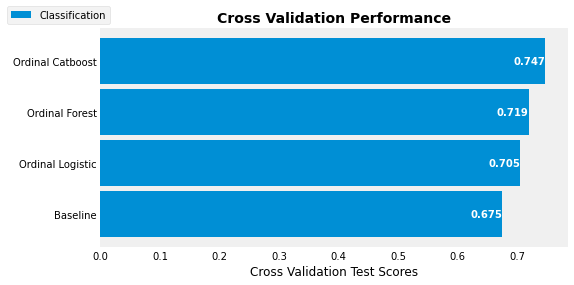

In [466]:
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(col_n_c, sorted(models_c), height=.9, label='Classification')

for i, v in enumerate(sorted(models_c)):
    ax.text(v, i, str(round(v, 3)), va='center', ha='right', color='white',
            fontweight='bold')

ax.set_title("Cross Validation Performance", fontsize=14, fontweight='bold')

ax.set_xlabel('Cross Validation Test Scores', fontsize=12)

ax.grid(False)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.legend(bbox_to_anchor=(-.09,1.06), loc='center')
plt.savefig('Models Cross Validation Scores Performancess')
plt.show()

## Permutation Importances
- Model used: `Ordinal + CatBoost`

In [201]:
col = ['Distance_Feet', 'Street_Kind', 'Description_Length']
X_test_permute = X_test.copy()
X_test_permute[col] = np.random.permutation(X_test_permute[col])

In [202]:
perm_imp = permutation_importance(ord_cat_model, X_test, y_test, n_jobs=-1,
                                  random_state=17, n_repeats=10)

In [203]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

cat_imp = pd.DataFrame(data, index=X_test.columns)
cat_imp.sort_values('importances_mean', ascending=False, inplace=True)

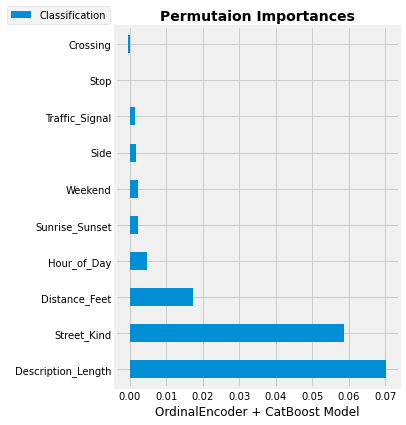

In [204]:
plt.subplots(figsize=(6,6))

cat_imp.importances_mean.plot(kind='barh', label='Classification')

plt.title('Permutaion Importances', fontsize=14, fontweight='bold')
plt.xlabel('OrdinalEncoder + CatBoost Model', fontsize=12)

plt.legend(bbox_to_anchor=(-.20,1.03), loc='center')
plt.tight_layout()

plt.savefig('Features Permutation from CatBoost')
plt.show()

## PDP Features
- Model used: `Ordinal + CatBoost`

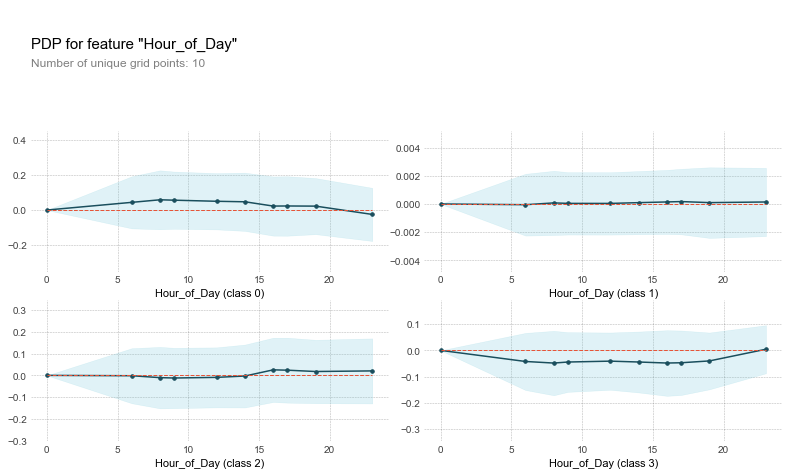

In [445]:
feature = 'Hour_of_Day'

X_test[feature] = X_test[feature].astype(int)

isolated = pdp_isolate(
    model=ord_cat_model,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature, figsize=(12,8))
plt.tight_layout()

plt.savefig('PDP Isolation Hour of Day from CatBoost')
plt.show()

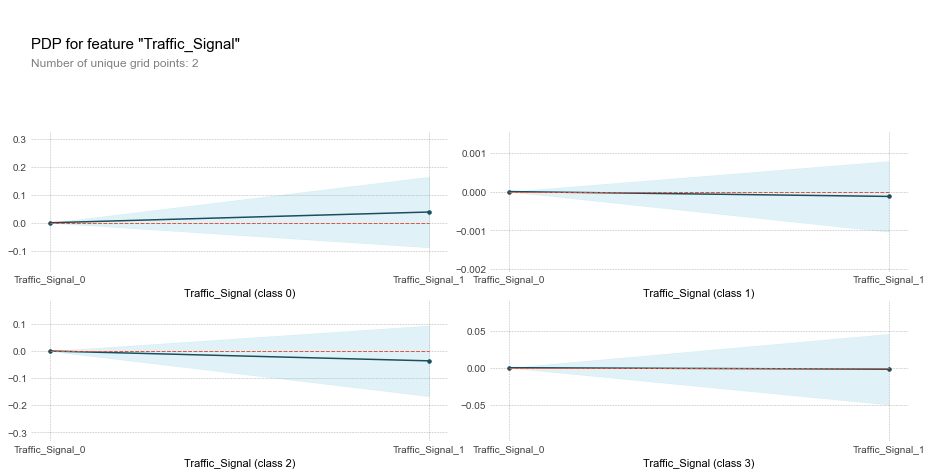

In [454]:
feature = 'Traffic_Signal'

X_test[feature] = X_test[feature].astype(int)

isolated = pdp_isolate(
    model=ord_cat_model,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature, figsize=(14,8))
plt.tight_layout()

plt.savefig('PDP Isolation Traffic Signal from CatBoost')
plt.show()

# SHAP
- Model used: `Ordinal + CatBoost`

In [323]:
X_test_sh = X_test.copy()

X_test_sh.Side = X_test_sh.Side.replace({'R':1,
                                         'L':0
})

X_test_sh.Street_Kind = X_test_sh.Street_Kind.replace({'Interstate':1,
                                                     'Highway':2,
                                                     'Road':3,
                                                     'Street':4,
                                                     'Avenue':5,
                                                     'Boulevard':6,
                                                     'Freeway':7,
                                                     'Drive':8,
                                                     'Parkway':9,
                                                     'Expressway':10,
                                                     'Lane':11,
                                                     'Turnpike':12,
                                                     'Pike':13,
                                                     'State Highway':14,
                                                     'Trail':15,
                                                     'Bridge':16,
                                                     'Toll':17,
                                                     'Throughway':18
})
                              
X_test_sh.Sunrise_Sunset = X_test_sh.Sunrise_Sunset.replace({'Day':1,
                                                             'Night':0
})

X_test_sh.Sunrise_Sunset = X_test_sh.Sunrise_Sunset.fillna(0)

X_test_sh = X_test_sh.astype('int64')

cat_features = list(range(0, X_test_sh.shape[1]))

In [324]:
shap_cat_model = CatBoostClassifier(iterations=500, random_state=17, learning_rate=0.85)
shap_cat_model.fit(X_test_sh, y_test, cat_features=cat_features, plot=False, verbose=True);

0:	learn: 0.7503852	total: 474ms	remaining: 3m 56s
1:	learn: 0.6852698	total: 937ms	remaining: 3m 53s
2:	learn: 0.6650124	total: 1.32s	remaining: 3m 38s
3:	learn: 0.6551736	total: 1.85s	remaining: 3m 49s
4:	learn: 0.6495244	total: 2.24s	remaining: 3m 41s
5:	learn: 0.6431954	total: 2.69s	remaining: 3m 41s
6:	learn: 0.6372229	total: 3.11s	remaining: 3m 38s
7:	learn: 0.6341894	total: 3.45s	remaining: 3m 32s
8:	learn: 0.6316680	total: 3.85s	remaining: 3m 29s
9:	learn: 0.6273669	total: 4.37s	remaining: 3m 34s
10:	learn: 0.6243679	total: 4.96s	remaining: 3m 40s
11:	learn: 0.6212622	total: 5.41s	remaining: 3m 39s
12:	learn: 0.6193128	total: 5.75s	remaining: 3m 35s
13:	learn: 0.6180775	total: 6.11s	remaining: 3m 32s
14:	learn: 0.6171331	total: 6.59s	remaining: 3m 33s
15:	learn: 0.6157374	total: 6.97s	remaining: 3m 30s
16:	learn: 0.6148599	total: 7.38s	remaining: 3m 29s
17:	learn: 0.6129626	total: 7.77s	remaining: 3m 28s
18:	learn: 0.6101432	total: 8.09s	remaining: 3m 24s
19:	learn: 0.6091010	t

158:	learn: 0.5825417	total: 58.6s	remaining: 2m 5s
159:	learn: 0.5824288	total: 59s	remaining: 2m 5s
160:	learn: 0.5822877	total: 59.3s	remaining: 2m 4s
161:	learn: 0.5822136	total: 59.7s	remaining: 2m 4s
162:	learn: 0.5821383	total: 1m	remaining: 2m 4s
163:	learn: 0.5819855	total: 1m	remaining: 2m 3s
164:	learn: 0.5819075	total: 1m	remaining: 2m 3s
165:	learn: 0.5816971	total: 1m 1s	remaining: 2m 3s
166:	learn: 0.5815887	total: 1m 1s	remaining: 2m 2s
167:	learn: 0.5814561	total: 1m 1s	remaining: 2m 2s
168:	learn: 0.5813530	total: 1m 2s	remaining: 2m 1s
169:	learn: 0.5811742	total: 1m 2s	remaining: 2m 1s
170:	learn: 0.5810834	total: 1m 3s	remaining: 2m 1s
171:	learn: 0.5809668	total: 1m 3s	remaining: 2m
172:	learn: 0.5809014	total: 1m 3s	remaining: 2m
173:	learn: 0.5808282	total: 1m 4s	remaining: 2m
174:	learn: 0.5807921	total: 1m 4s	remaining: 1m 59s
175:	learn: 0.5807601	total: 1m 4s	remaining: 1m 59s
176:	learn: 0.5805692	total: 1m 5s	remaining: 1m 58s
177:	learn: 0.5804231	total: 

312:	learn: 0.5699886	total: 1m 53s	remaining: 1m 7s
313:	learn: 0.5698867	total: 1m 53s	remaining: 1m 7s
314:	learn: 0.5698358	total: 1m 54s	remaining: 1m 7s
315:	learn: 0.5697844	total: 1m 54s	remaining: 1m 6s
316:	learn: 0.5697269	total: 1m 54s	remaining: 1m 6s
317:	learn: 0.5696172	total: 1m 55s	remaining: 1m 5s
318:	learn: 0.5695605	total: 1m 55s	remaining: 1m 5s
319:	learn: 0.5694954	total: 1m 56s	remaining: 1m 5s
320:	learn: 0.5694662	total: 1m 56s	remaining: 1m 4s
321:	learn: 0.5693914	total: 1m 56s	remaining: 1m 4s
322:	learn: 0.5693228	total: 1m 57s	remaining: 1m 4s
323:	learn: 0.5692102	total: 1m 57s	remaining: 1m 3s
324:	learn: 0.5691358	total: 1m 57s	remaining: 1m 3s
325:	learn: 0.5691000	total: 1m 58s	remaining: 1m 3s
326:	learn: 0.5690136	total: 1m 58s	remaining: 1m 2s
327:	learn: 0.5689406	total: 1m 58s	remaining: 1m 2s
328:	learn: 0.5689128	total: 1m 59s	remaining: 1m 2s
329:	learn: 0.5688693	total: 1m 59s	remaining: 1m 1s
330:	learn: 0.5687468	total: 2m	remaining: 1m 

468:	learn: 0.5595819	total: 2m 49s	remaining: 11.2s
469:	learn: 0.5595097	total: 2m 49s	remaining: 10.8s
470:	learn: 0.5594939	total: 2m 50s	remaining: 10.5s
471:	learn: 0.5594481	total: 2m 50s	remaining: 10.1s
472:	learn: 0.5593652	total: 2m 50s	remaining: 9.74s
473:	learn: 0.5593042	total: 2m 51s	remaining: 9.38s
474:	learn: 0.5592769	total: 2m 51s	remaining: 9.02s
475:	learn: 0.5592295	total: 2m 51s	remaining: 8.66s
476:	learn: 0.5591332	total: 2m 52s	remaining: 8.3s
477:	learn: 0.5590522	total: 2m 52s	remaining: 7.94s
478:	learn: 0.5590014	total: 2m 52s	remaining: 7.58s
479:	learn: 0.5589689	total: 2m 53s	remaining: 7.21s
480:	learn: 0.5589321	total: 2m 53s	remaining: 6.86s
481:	learn: 0.5588571	total: 2m 53s	remaining: 6.49s
482:	learn: 0.5588172	total: 2m 54s	remaining: 6.13s
483:	learn: 0.5587613	total: 2m 54s	remaining: 5.77s
484:	learn: 0.5586498	total: 2m 54s	remaining: 5.41s
485:	learn: 0.5585953	total: 2m 55s	remaining: 5.05s
486:	learn: 0.5584592	total: 2m 55s	remaining: 

In [325]:
shap_values = shap_cat_model.get_feature_importance(Pool(X_test_sh, y_test, cat_features=cat_features), 
                                                    type='ShapValues')

In [326]:
explainer = shap.TreeExplainer(shap_cat_model)
shap_values = explainer.shap_values(X_test_sh)

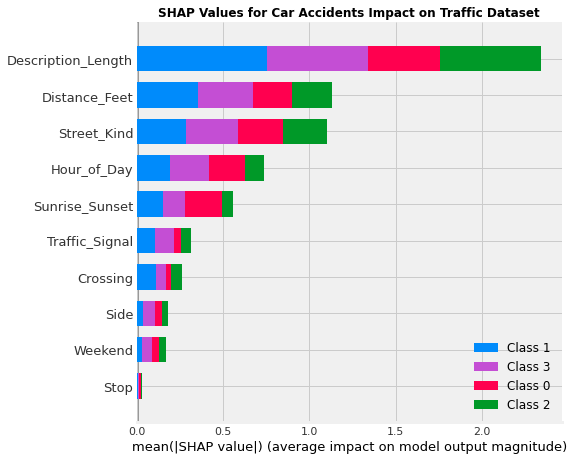

In [327]:
shap.summary_plot(shap_values, X_test_sh, plot_type='bar', show=False, plot_size=.5)

plt.title('SHAP Values for Car Accidents Impact on Traffic Dataset', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('SHAP Summary Plot from CatBoost')
plt.show()

# Other

In [448]:
df19 = df.copy()
df20 = df.copy()

df19 = df19[df19.index == 2019]
df20 = df20[df20.index == 2020]

df19['Week_Num_Year'] = df19['Week_Num_Year'].astype('int64')
df20['Week_Num_Year'] = df20['Week_Num_Year'].astype('int64')

df19 = df19[df19['Week_Num_Year'] < 29]
df20 = df20[df20['Week_Num_Year'] < 29]

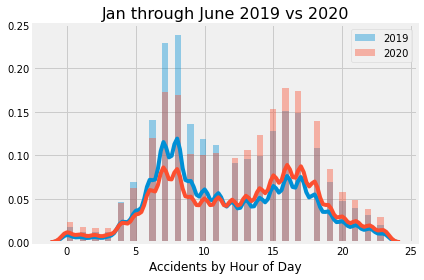

In [449]:
sns.distplot(df19['Hour_of_Day'], label='2019')
sns.distplot(df20['Hour_of_Day'], label='2020')
plt.title('Jan through June 2019 vs 2020', fontsize=16)
plt.xlabel('Accidents by Hour of Day')
plt.tight_layout()
plt.legend()
plt.savefig('SNS Displot for Hour of Day')
plt.show()

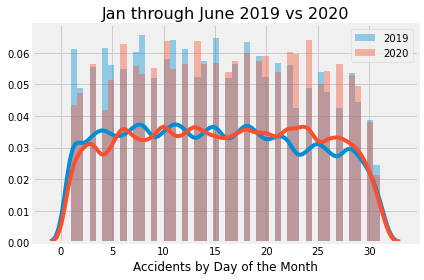

In [450]:
sns.distplot(df19['Day_of_Month'], label='2019')
sns.distplot(df20['Day_of_Month'], label='2020')
plt.title('Jan through June 2019 vs 2020', fontsize=16)
plt.xlabel('Accidents by Day of the Month')
plt.tight_layout()
plt.legend()
plt.savefig('SNS Displot for Day of the Month')
plt.show()

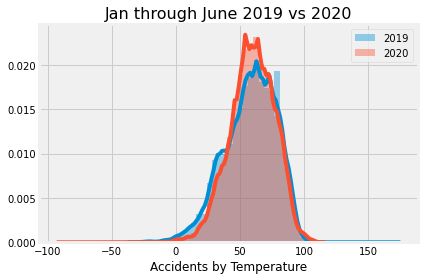

In [451]:
sns.distplot(df19['Temperature(F)'], label='2019')
sns.distplot(df20['Temperature(F)'], label='2020')
plt.title('Jan through June 2019 vs 2020', fontsize=16)
plt.xlabel('Accidents by Temperature')
plt.tight_layout()
plt.legend()
plt.savefig('SNS Displot for Temperature')
plt.show()

In [452]:
end_time = time()
time = end_time - start_time
hours = time//3600
time = time - 3600*hours
minutes = time//60
seconds = time - 60*minutes
print('Notebook Lasted:')
print('%d:%d:%d' %(hours,minutes,seconds))

Notebook Lasted:
1:7:7
